In [1]:
import torch
import torchaudio
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import textgrid
import math
import pyworld as pw

In [12]:
name = "00000006"
waveform, sr = torchaudio.load(f"./datasets/eval-prepared/00000000/{name}.wav")
assert sr == 16000
tg = textgrid.TextGrid.fromFile(f"./datasets/eval-aligned/00000000/{name}.TextGrid")
f0 = torch.load(f"./datasets/eval-prepared/00000000/{name}.f0.pt")
f02, t0 = pw.dio(waveform.squeeze(0).numpy().astype('double'), 16000, frame_period=(1000 * 160)/16000) # 1000ms * (hop/sample_rate)
f03 = pw.stonemask(waveform.squeeze(0).numpy().astype('double'), f02, t0, 16000)
# f0 = (256 * (torch.log(torch.tensor(f0) + 1) / 7)).int().float()
phones = tg[1]

def _convert_to_continuous_f0(f0):
    nonzero_f0 = f0[f0 != 0]
    if len(nonzero_f0) > 0:  # Check if there are any non-zero values
        start_f0 = nonzero_f0[0]
        end_f0 = nonzero_f0[-1]
        start_idx = (f0 == start_f0).nonzero(as_tuple=True)[0][0]
        end_idx = (f0 == end_f0).nonzero(as_tuple=True)[0][-1]
        f0[:start_idx] = start_f0
        f0[end_idx + 1:] = end_f0  # Adding 1 to end_idx to include the end value itself

        # get non-zero frame index and corresponding f0 values
        nonzero_idxs = (f0 != 0).nonzero(as_tuple=True)[0]
        nonzero_f0_values = f0[nonzero_idxs]

        # perform linear interpolation
        interp_f0 = torch.zeros_like(f0)
        for i in range(len(nonzero_idxs) - 1):
            start_idx, end_idx = nonzero_idxs[i], nonzero_idxs[i + 1]
            interp_values = torch.linspace(nonzero_f0_values[i], nonzero_f0_values[i + 1], steps=end_idx - start_idx + 1)
            interp_f0[start_idx:end_idx + 1] = interp_values

        return interp_f0
    else:
        return f0

f04 = _convert_to_continuous_f0(torch.tensor(f02))
f05 = _convert_to_continuous_f0(torch.tensor(f03))

last_phone_time = 0
data = []
for phone in phones:

    # Silence
    if phone.minTime != last_phone_time:
        count = round((phone.minTime - last_phone_time) / 0.01)
        v = f0[round(last_phone_time / 0.01): round(phone.minTime / 0.01)].median().item()
        for c in range(count):
            data.append(v)
        last_phone_time = phone.minTime

    # Phoneme
    count = round((phone.maxTime - phone.minTime) / 0.01)
    v = f0[round(phone.minTime / 0.01): round(phone.maxTime / 0.01)].median().item()
    for c in range(count):
        data.append(v)
    last_phone_time = phone.maxTime
print(t0)
# data = (256 * (torch.log(torch.tensor(data) + 1) / 7)).int()
# f0 = (256 * (torch.log(torch.tensor(f0) + 1) / 7)).int()

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

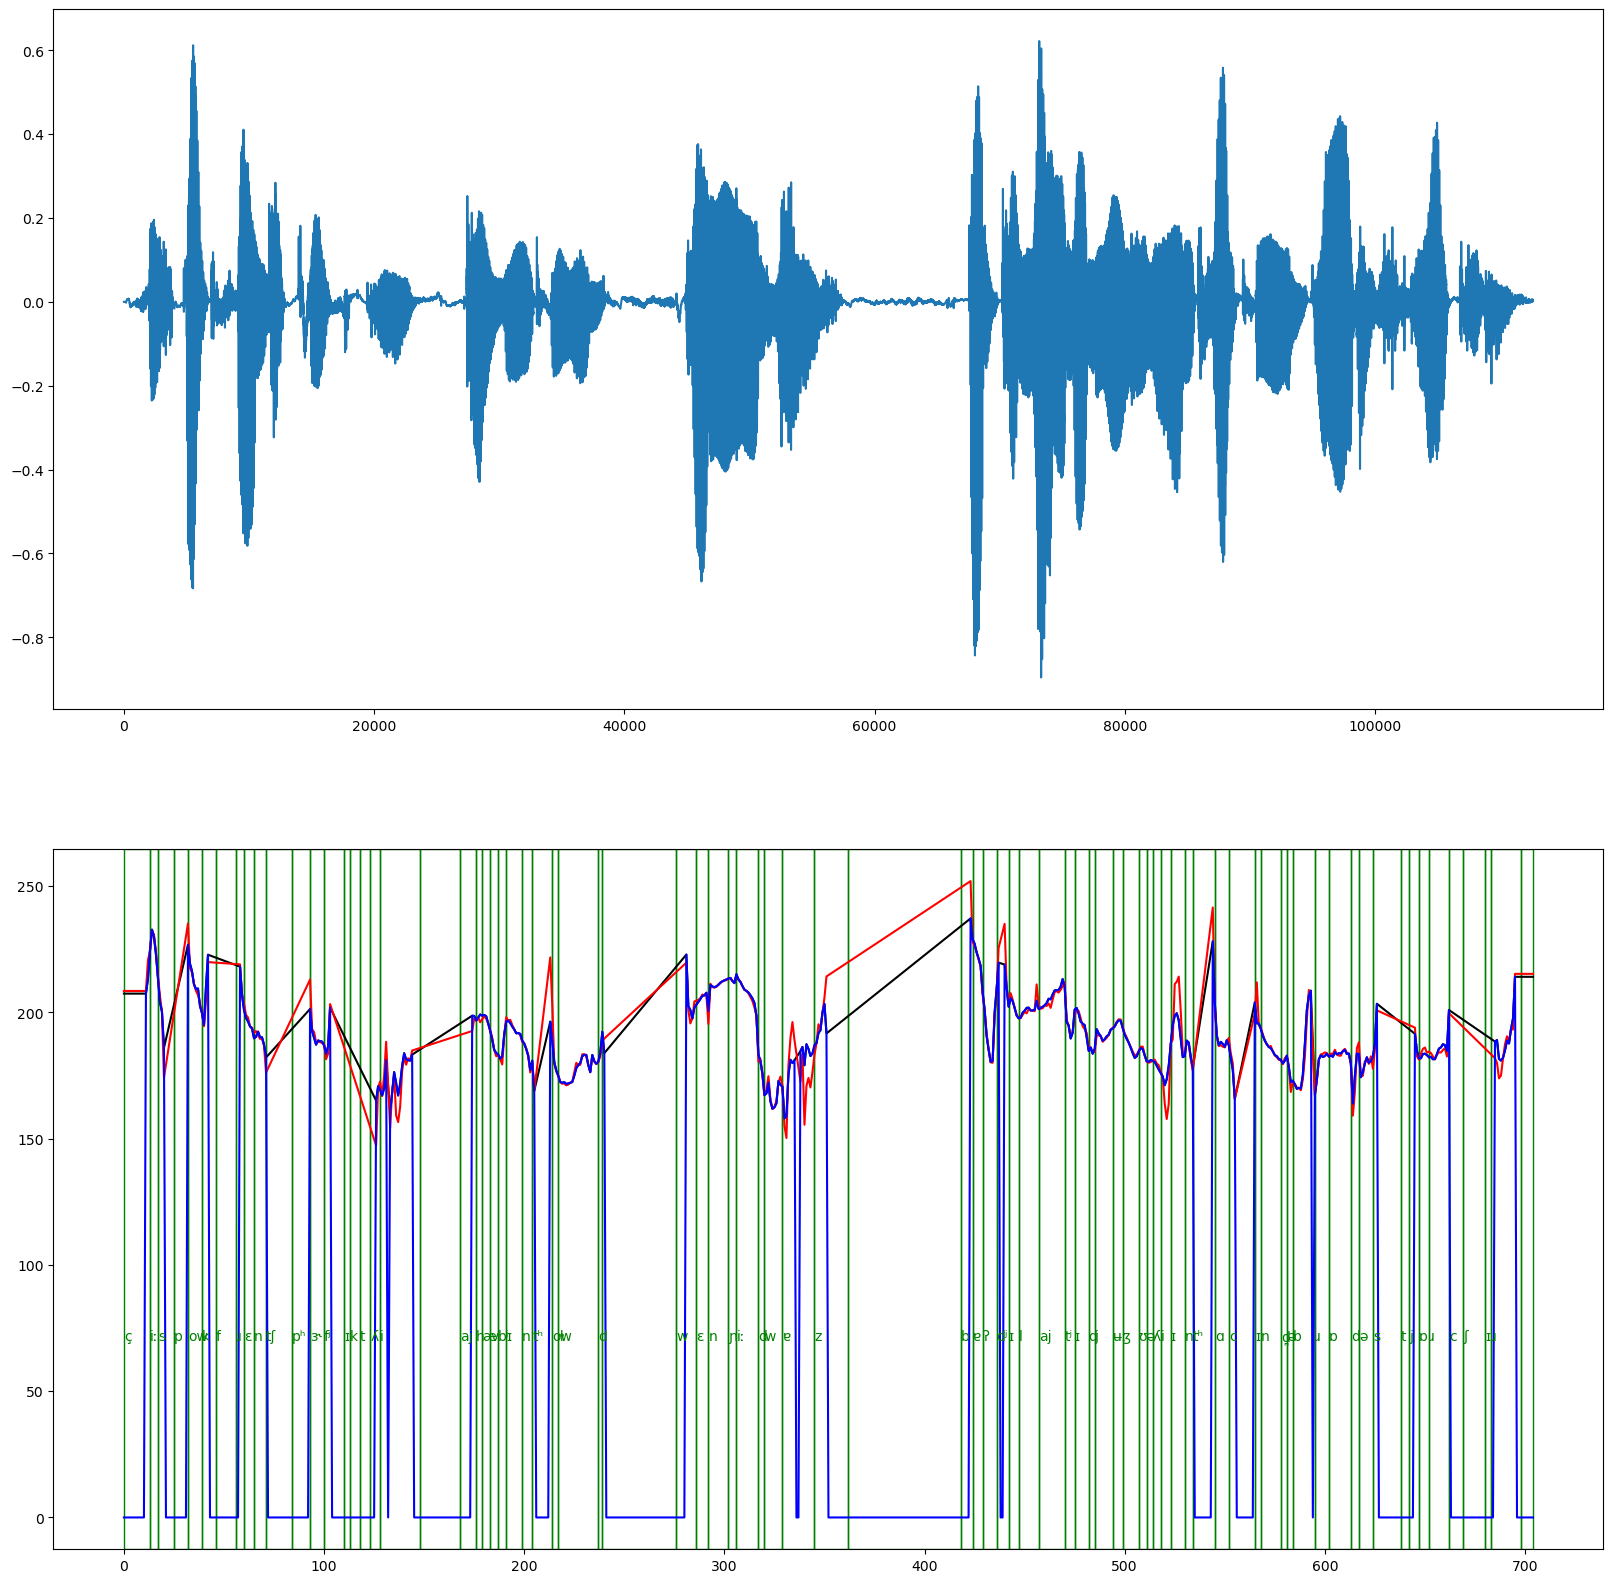

In [14]:
display(Audio(data=waveform, rate=16000))

_, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].plot(waveform[0])
# ax[1].plot(f03, color="yellow")
# ax[1].plot(f0, color="purple")
ax[1].plot(f04, color="black")
ax[1].plot(f05, color="red")
# ax[1].plot(f02, color="blue")
ax[1].plot(f02, color="blue")
# ax[1].bar(range(len(data)), data, color="purple")
# for span in tg[0]:
#     span_start = int(span.minTime // 0.01)
#     span_end = int(span.maxTime // 0.01)
#     ax[1].axvspan(span_start, span_end, facecolor="None", edgecolor="black")
#     ax[1].annotate(span.mark, (span_start, 75), annotation_clip=True, color="black")
for span in tg[1]:
    span_start = round(span.minTime / 0.01)
    span_end = round(span.maxTime / 0.01)
    # print(span_start, span_end, span.minTime, span.maxTime, span.mark)
    ax[1].axvspan(span_start, span_end, facecolor="None", edgecolor="green")
    ax[1].annotate(span.mark, (span_start, 70), annotation_clip=True, color="green")